In [1]:
import pandas as pd
import glob
import os

In [2]:
DATA_PATH = "../data/raw"

In [ ]:
# Years to load
#YEARS = [2020, 2021, 2022, 2023, 2024, 2025]
YEARS = [2021]

# -------------------------------
# Helper function: load and merge yearly data
# -------------------------------
def load_vaers_year(year):
    print(f"Loading VAERS data for {year}...")

    data_file = os.path.join(DATA_PATH, f"{year}VAERSDATA.csv")
    symp_file = os.path.join(DATA_PATH, f"{year}VAERSSYMPTOMS.csv")
    vax_file  = os.path.join(DATA_PATH, f"{year}VAERSVAX.csv")

    # Load CSVs
    df_data = pd.read_csv(data_file, encoding="latin-1", low_memory=False)
    df_symp = pd.read_csv(symp_file, encoding="latin-1", low_memory=False)
    df_vax  = pd.read_csv(vax_file, encoding="latin-1", low_memory=False)

    # Merge
    df = df_data.merge(df_symp, on="VAERS_ID", how="left")
    df = df.merge(df_vax, on="VAERS_ID", how="left")

    # Filter only COVID-19 vaccines
    df = df[df["VAX_TYPE"].str.contains("COVID19", na=False)]

    # Add YEAR column
    df["YEAR"] = year

    return df

# -------------------------------
# Load all years
# -------------------------------
all_years = [load_vaers_year(y) for y in YEARS]
df_all = pd.concat(all_years, ignore_index=True)
print(f"Raw merged dataset: {df_all.shape}")

# -------------------------------
# Deduplicate per patient (VAERS_ID)
# -------------------------------
symptom_cols = ["SYMPTOM1","SYMPTOM2","SYMPTOM3","SYMPTOM4","SYMPTOM5"]

def join_unique(series):
    """Helper to join unique non-null values into one string"""
    return " | ".join(sorted(set(series.dropna().astype(str))))

df_dedup = (
    df_all.groupby("VAERS_ID")
    .agg({
        "YEAR": "first",
        "AGE_YRS": "first",
        "SEX": "first",
        "SYMPTOM_TEXT": "first",    # narrative is usually same across duplicates
        "HOSPITAL": "first",
        "L_THREAT": "first",
        "DIED": "first",
        "DISABLE": "first",
        "VAX_TYPE": join_unique,
        "VAX_NAME": join_unique,
        "VAX_MANU": join_unique,
        "SYMPTOM1": join_unique,
        "SYMPTOM2": join_unique,
        "SYMPTOM3": join_unique,
        "SYMPTOM4": join_unique,
        "SYMPTOM5": join_unique,
    })
    .reset_index()
)

# -------------------------------
# Clean text
# -------------------------------
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower().replace("\n", " ").replace("\r", " ")
    return text

df_dedup["SYMPTOM_TEXT"] = df_dedup["SYMPTOM_TEXT"].apply(clean_text)

# Merge structured symptom columns
#df_dedup["SYMPTOMS_STRUCT"] = df_dedup[symptom_cols].fillna("").agg(" | ".join, axis=1)

# Final narrative field
#df_dedup["FINAL_SYMPTOM_TEXT"] = (
#    df_dedup["SYMPTOM_TEXT"].fillna("") + " | " + df_dedup["SYMPTOMS_STRUCT"]
#)

# -------------------------------
# Keep lean schema for ADEGuard
# -------------------------------
keep_cols = [
    "VAERS_ID", "YEAR", "AGE_YRS", "SEX",
    "VAX_TYPE", "VAX_NAME", "VAX_MANU",
    "SYMPTOM_TEXT","SYMPTOM1",
    "HOSPITAL", "L_THREAT", "DIED", "DISABLE"
]
df_adeguard = df_dedup[keep_cols]

# -------------------------------
# Save outputs
# -------------------------------
df_adeguard.to_csv("covid_vaers_2020_adeguard.csv.gz", index=False, compression="gzip")
df_adeguard.to_parquet("covid_vaers_2020_adeguard.parquet", engine="pyarrow", index=False)

# -------------------------------
# ✅ Sanity Check
# -------------------------------
print("\n--- Sanity Check ---")
print("Total records (deduplicated):", len(df_adeguard))
print("Duplicate VAERS_IDs:", df_adeguard["VAERS_ID"].duplicated().sum())
print("Unique VAERS_IDs:", df_adeguard["VAERS_ID"].nunique())

# Peek at random rows
print("\nSample rows:")
print(df_adeguard.sample(3, random_state=42))


In [4]:

!pip install wordcloud

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [16]:
all_symptoms = df_adeguard['SYMPTOMS_STRUCT'].head(50).tolist()

In [17]:
all_symptoms

['Pulmonary embolism |  |  |  | ',
 'Ear discomfort | Feeling abnormal | Ear pruritus | Pruritus | Laboratory test normal | Tinnitus | Rash | Tinnitus',
 'Abdominal pain | Diverticulitis | Abscess | Blood test | Computerised tomogram abdomen | Computerised tomogram pelvis',
 'Hypoaesthesia | Injection site hypoaesthesia |  |  | ',
 'Headache |  |  |  | ',
 'Erythema | Feeling hot | Flushing |  | ',
 'Dizziness | Electrocardiogram normal | Hyperhidrosis | Laboratory test normal | Presyncope',
 'Dysgeusia | Sensory disturbance | Oral pruritus | Tremor | Paraesthesia | Paraesthesia oral | Parosmia',
 'Chest discomfort | Dyspnoea | Chills | Feeling abnormal | Defaecation urgency | Flushing | Diarrhoea | Presyncope | Dizziness',
 'Anxiety | Chest pain | Cyanosis | Pollakiuria | Blood pressure systolic increased | Dyspnoea | Feeling abnormal | Sensory disturbance | Chest discomfort | Feeling abnormal | Flushing | Chills | Intensive care | Cold sweat | Pallor',
 'Headache | Pain |  |  | ',
 '

In [18]:
all_symptoms_string = ' '.join(all_symptoms)

In [19]:
all_symptoms_string

'Pulmonary embolism |  |  |  |  Ear discomfort | Feeling abnormal | Ear pruritus | Pruritus | Laboratory test normal | Tinnitus | Rash | Tinnitus Abdominal pain | Diverticulitis | Abscess | Blood test | Computerised tomogram abdomen | Computerised tomogram pelvis Hypoaesthesia | Injection site hypoaesthesia |  |  |  Headache |  |  |  |  Erythema | Feeling hot | Flushing |  |  Dizziness | Electrocardiogram normal | Hyperhidrosis | Laboratory test normal | Presyncope Dysgeusia | Sensory disturbance | Oral pruritus | Tremor | Paraesthesia | Paraesthesia oral | Parosmia Chest discomfort | Dyspnoea | Chills | Feeling abnormal | Defaecation urgency | Flushing | Diarrhoea | Presyncope | Dizziness Anxiety | Chest pain | Cyanosis | Pollakiuria | Blood pressure systolic increased | Dyspnoea | Feeling abnormal | Sensory disturbance | Chest discomfort | Feeling abnormal | Flushing | Chills | Intensive care | Cold sweat | Pallor Headache | Pain |  |  |  Blood pressure increased | Dizziness | Nausea

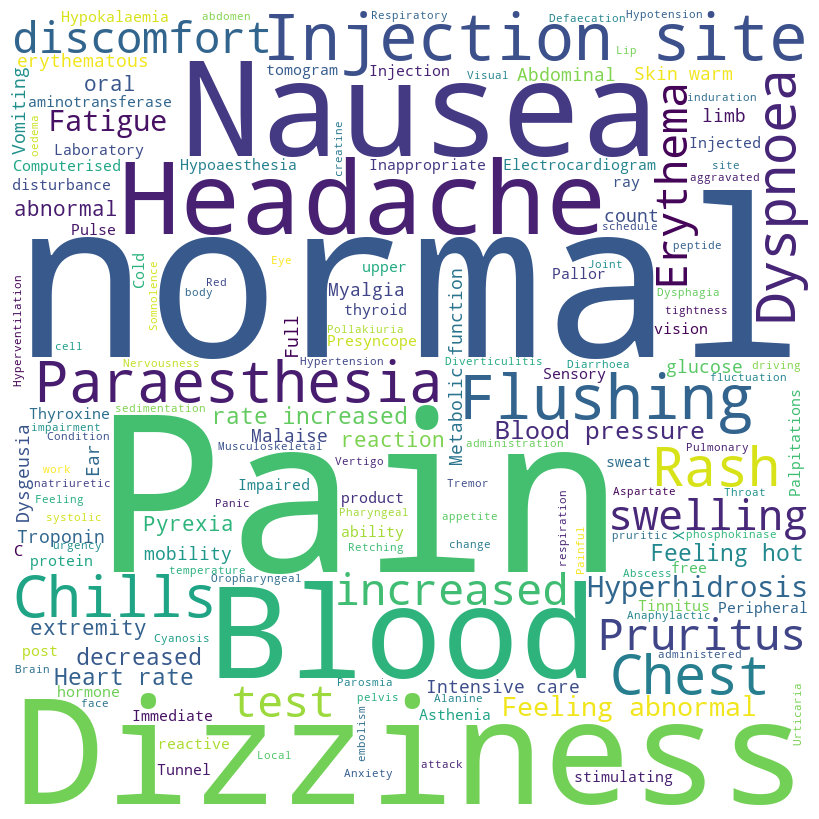

In [20]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color ='white',
                      min_font_size = 10).generate(all_symptoms_string)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [21]:
df_adeguard['VAX_NAME'].unique()

array(['COVID19 (COVID19 (MODERNA))',
       'COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (JANSSEN))', 'COVID19 (COVID19 (UNKNOWN))',
       'COVID19 (COVID19 (MODERNA)) | COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (PFIZER-BIONTECH)) | COVID19 (COVID19 (UNKNOWN))',
       'COVID19 (COVID19 (MODERNA)) | COVID19 (COVID19 (UNKNOWN))',
       'COVID19 (COVID19 (JANSSEN)) | COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (JANSSEN)) | COVID19 (COVID19 (UNKNOWN))',
       'COVID19 (COVID19 (JANSSEN)) | COVID19 (COVID19 (MODERNA))',
       'COVID19 (COVID19 (MODERNA)) | COVID19 (COVID19 (PFIZER-BIONTECH)) | COVID19 (COVID19 (UNKNOWN))',
       'COVID19 (COVID19 (PFIZER-BIONTECH BIVALENT)) | COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (MODERNA BIVALENT)) | COVID19 (COVID19 (MODERNA))',
       'COVID19 (COVID19 (JANSSEN)) | COVID19 (COVID19 (MODERNA)) | COVID19 (COVID19 (PFIZER-BIONTECH))',
       'COVID19 (COVID19 (MODERNA